# Data exploration

In [ ]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
from glob import glob
import random
random.seed(123)

In [ ]:
path1 ="oct/train"
path2 ="oct/test"
path3 ="oct/val"

In [ ]:
myList = os.listdir(path1)
print("Total Number of Classes Detected :",len(myList))


Total Number of Classes Detected : 4


In [ ]:
random.seed(123)
noOfclasses= len(myList)
print(myList)

['NORMAL', 'DME', 'CNV', 'DRUSEN']


In [ ]:
main_dir = os.listdir('oct/')
print(main_dir)

for i in main_dir:
    data_dir_list =  os.listdir('oct/'+ str(i) )
    print(i, data_dir_list)

['val', 'test', 'train']
val ['NORMAL', 'DME', 'CNV', 'DRUSEN']
test ['NORMAL', 'DME', 'CNV', 'DRUSEN']
train ['NORMAL', 'DME', 'CNV', 'DRUSEN']


In [ ]:
normal_len = len(os.listdir("oct/train/NORMAL"))
drusen_len = len(os.listdir("oct/train/DRUSEN"))
cnv_len = len(os.listdir("oct/train/CNV"))
dme_len = len(os.listdir("oct/train/DME"))

print("length of images with drusen = ",drusen_len)
print("length of images with cnv = ",cnv_len)
print("length of images with dme = ",dme_len)
print("length of images with normal = ",normal_len)

length of images with drusen =  8366
length of images with cnv =  36955
length of images with dme =  11098
length of images with normal =  26065


Normal


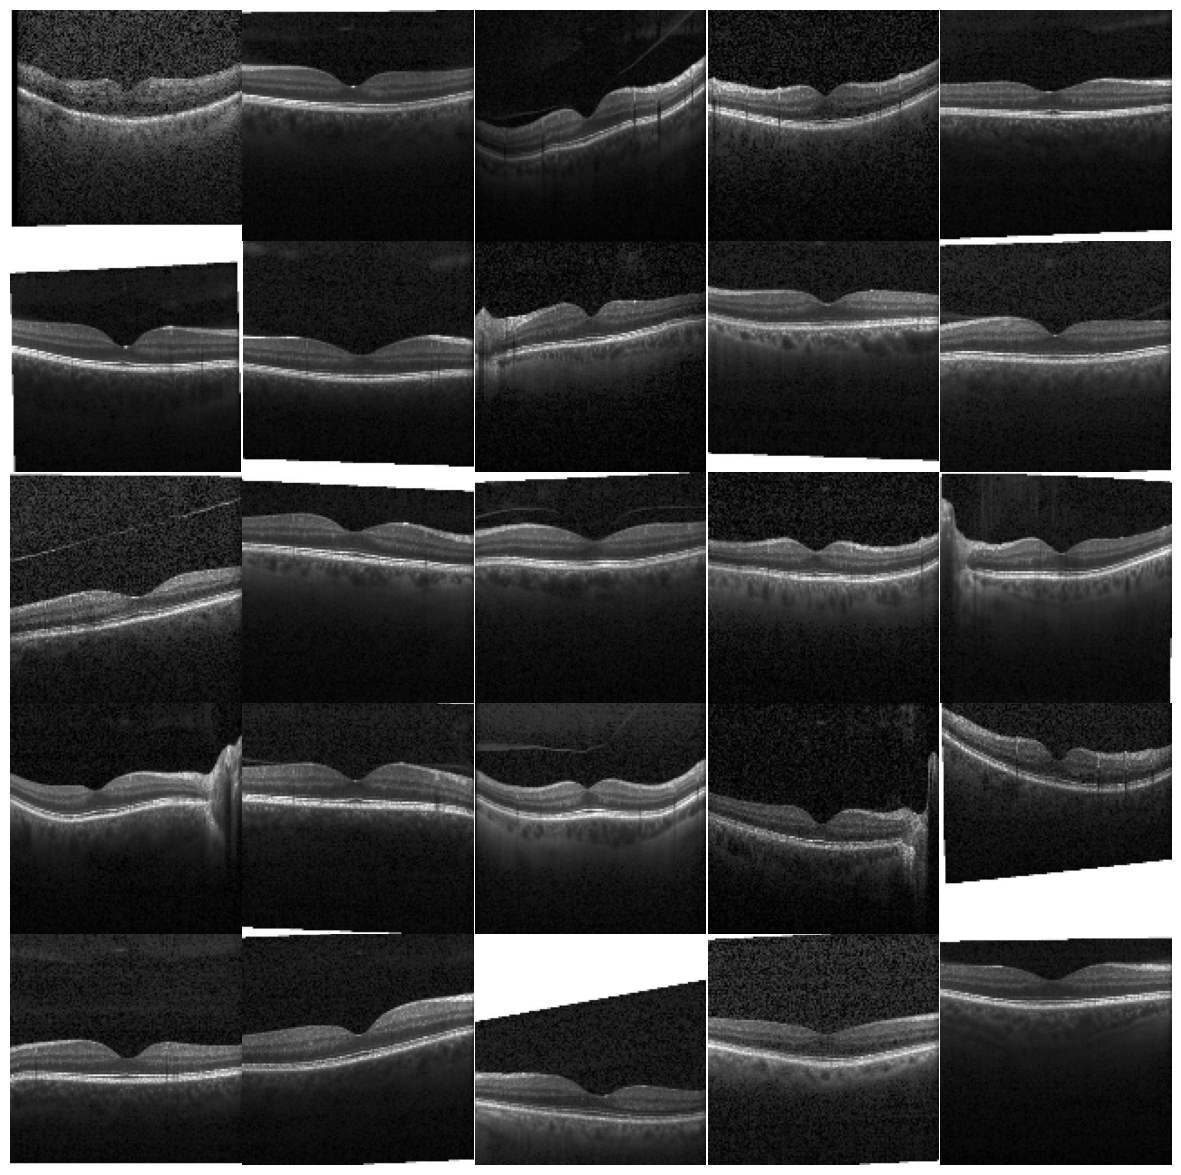

In [ ]:
print("Normal")
multipleImages = glob('oct/train/NORMAL/**')
i_ = 0
plt.rcParams['figure.figsize'] = (15.0, 15.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128))
    plt.subplot(5, 5, i_+1)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

DME


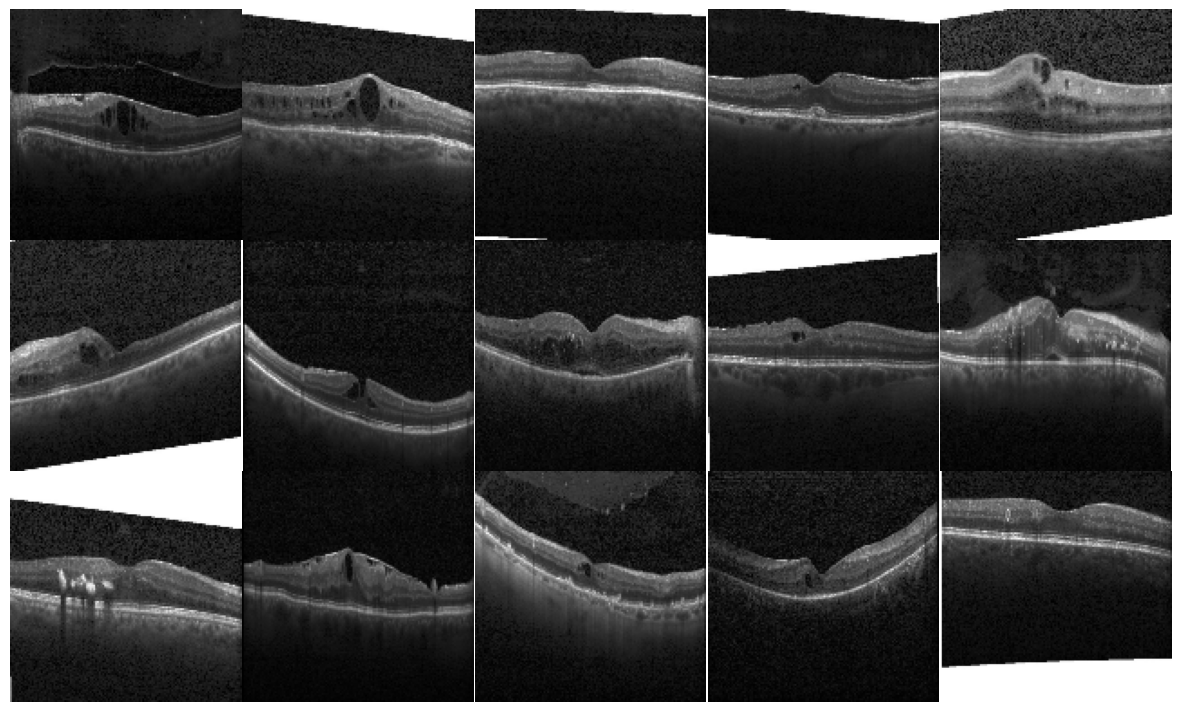

In [ ]:
print("DME")
multipleImages = glob('oct/train/DME/**')
i_ = 0
plt.rcParams['figure.figsize']  =  (15.0, 15.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:15]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128))
    plt.subplot(5, 5, i_+1)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

# Model checkpoint

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
model_checkpoint = "microsoft/swinv2-tiny-patch4-window8-256"
batch_size = 150

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

# Loading complete data

In [ ]:
from datasets import load_dataset
dataset = load_dataset("imagefolder", data_dir="oct")

<frozen importlib._bootstrap>:228: RuntimeWarning: pyarrow._fs.FileInfo size changed, may indicate binary incompatibility. Expected 64 from C header, got 88 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: pyarrow._fs.FileSelector size changed, may indicate binary incompatibility. Expected 48 from C header, got 72 from PyObject


Resolving data files:   0%|          | 0/82484 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1000 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 82484
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1000
    })
})

In [ ]:
from datasets import load_metric

metric = load_metric("accuracy")

/tmp/ipykernel_597465/1780215247.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [ ]:
example = dataset["train"][10]
example

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=512x496>,
 'label': 0}

In [ ]:
dataset["train"].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['CNV', 'DME', 'DRUSEN', 'NORMAL'], id=None)}

In [ ]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label



# Data preprocessing

In [ ]:
from transformers import AutoImageProcessor

image_processor  = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor

2023-12-04 08:57:58.593902: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-04 08:57:58.637506: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-04 08:57:58.637551: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-04 08:57:58.637584: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-04 08:57:58.647810: I tensorflow/core/platform/cpu_feature_g

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 256,
    "width": 256
  }
}

In [ ]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            Resize(size),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [ ]:
test_ds = dataset['test']
train_ds = dataset['train']
val_ds = dataset['validation']

In [ ]:
train_ds

Dataset({
    features: ['image', 'label'],
    num_rows: 82484
})

In [ ]:
val_ds

Dataset({
    features: ['image', 'label'],
    num_rows: 1000
})

In [ ]:
test_ds

Dataset({
    features: ['image', 'label'],
    num_rows: 1000
})

In [ ]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)
test_ds.set_transform(preprocess_val)

# Model training

In [ ]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True,
    # device='auto'
)


Some weights of Swinv2ForImageClassification were not initialized from the model checkpoint at microsoft/swinv2-tiny-patch4-window8-256 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"/media/iiit/Karvalo/zuhair/abhiram/{model_name}-finetuned-eurosat",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
    report_to="wandb"

)

In [ ]:
import numpy as np
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [ ]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
trainer = Trainer(
    model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [ ]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

wandb: Currently logged in as: zuhashaik12 (workspace_zuhas). Use `wandb login --relogin` to force relogin


/home/iiit/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,0.399100,0.207411,0.933000
2,0.162900,0.094567,0.971000
3,0.129400,0.069181,0.977000
4,0.116400,0.057169,0.982000
5,0.102800,0.049426,0.984000
6,0.089300,0.048662,0.982000
7,0.084300,0.047168,0.984000
8,0.080500,0.043737,0.983000
9,0.070500,0.052347,0.982000
10,0.071200,0.048240,0.983000


/home/iiit/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/iiit/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/iiit/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/iiit/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input 

***** train metrics *****
  epoch                    =          10.0
  total_flos               = 24994008273GF
  train_loss               =        0.1707
  train_runtime            =    1:51:24.62
  train_samples_per_second =       123.394
  train_steps_per_second   =         0.069


In [ ]:
metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

/home/iiit/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


***** eval metrics *****
  epoch                   =       10.0
  eval_accuracy           =      0.984
  eval_loss               =     0.0494
  eval_runtime            = 0:00:06.60
  eval_samples_per_second =    151.448
  eval_steps_per_second   =      0.454


/home/iiit/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


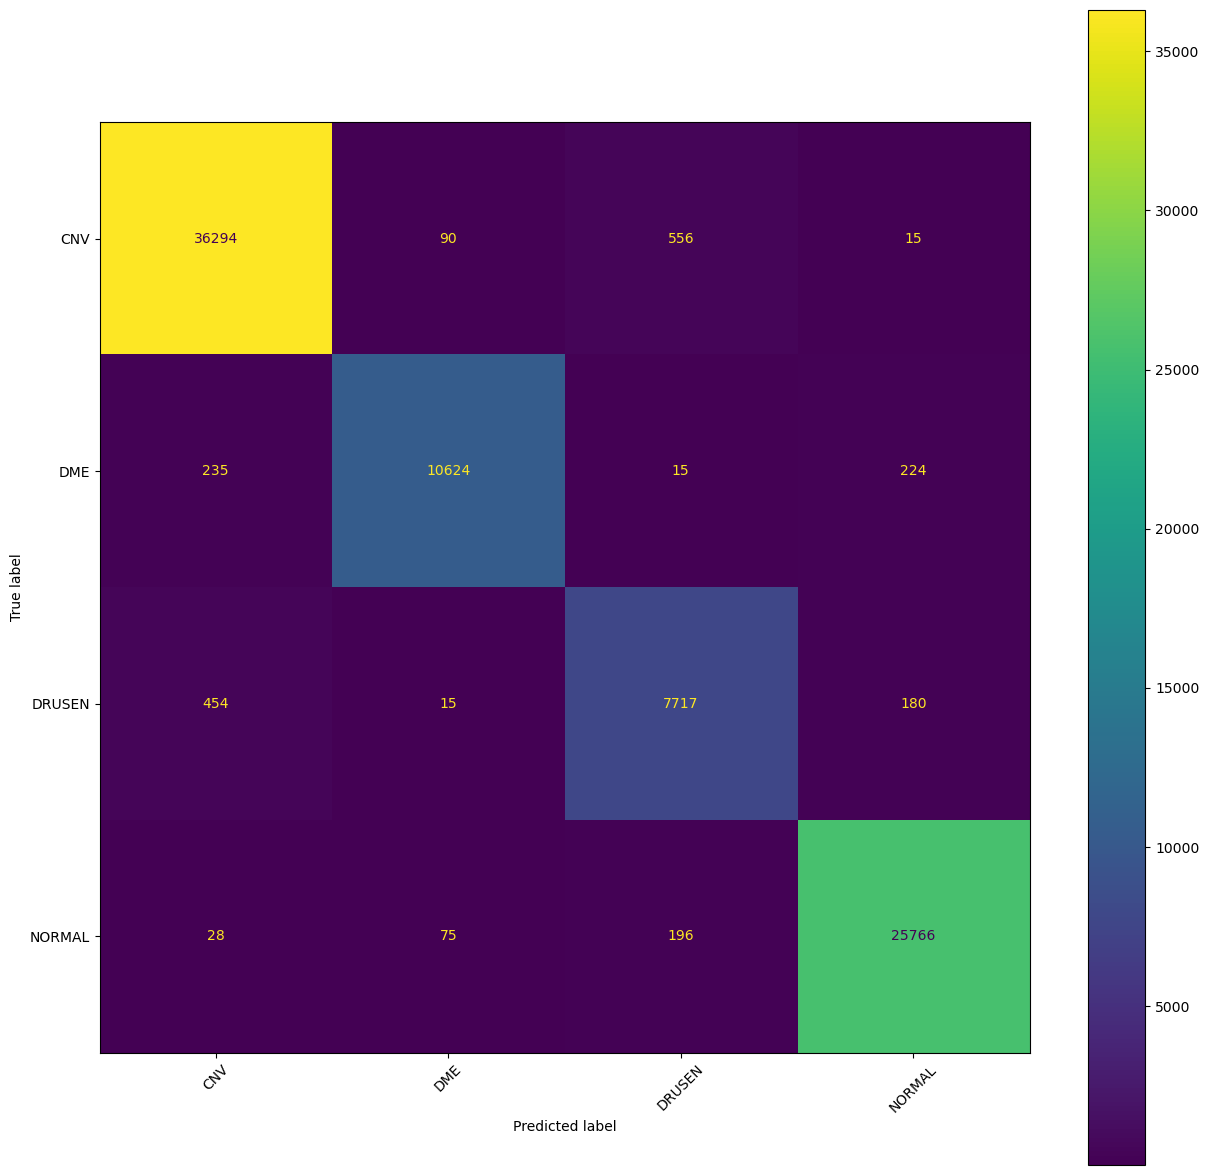

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
outputs = trainer.predict(train_ds)
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred, target_names=labels, digits=4)
print(report)

              precision    recall  f1-score   support

         CNV     0.9806    0.9821    0.9814     36955
         DME     0.9833    0.9573    0.9701     11098
      DRUSEN     0.9096    0.9224    0.9160      8366
      NORMAL     0.9840    0.9885    0.9863     26065

    accuracy                         0.9747     82484
   macro avg     0.9644    0.9626    0.9634     82484
weighted avg     0.9749    0.9747    0.9748     82484



/home/iiit/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


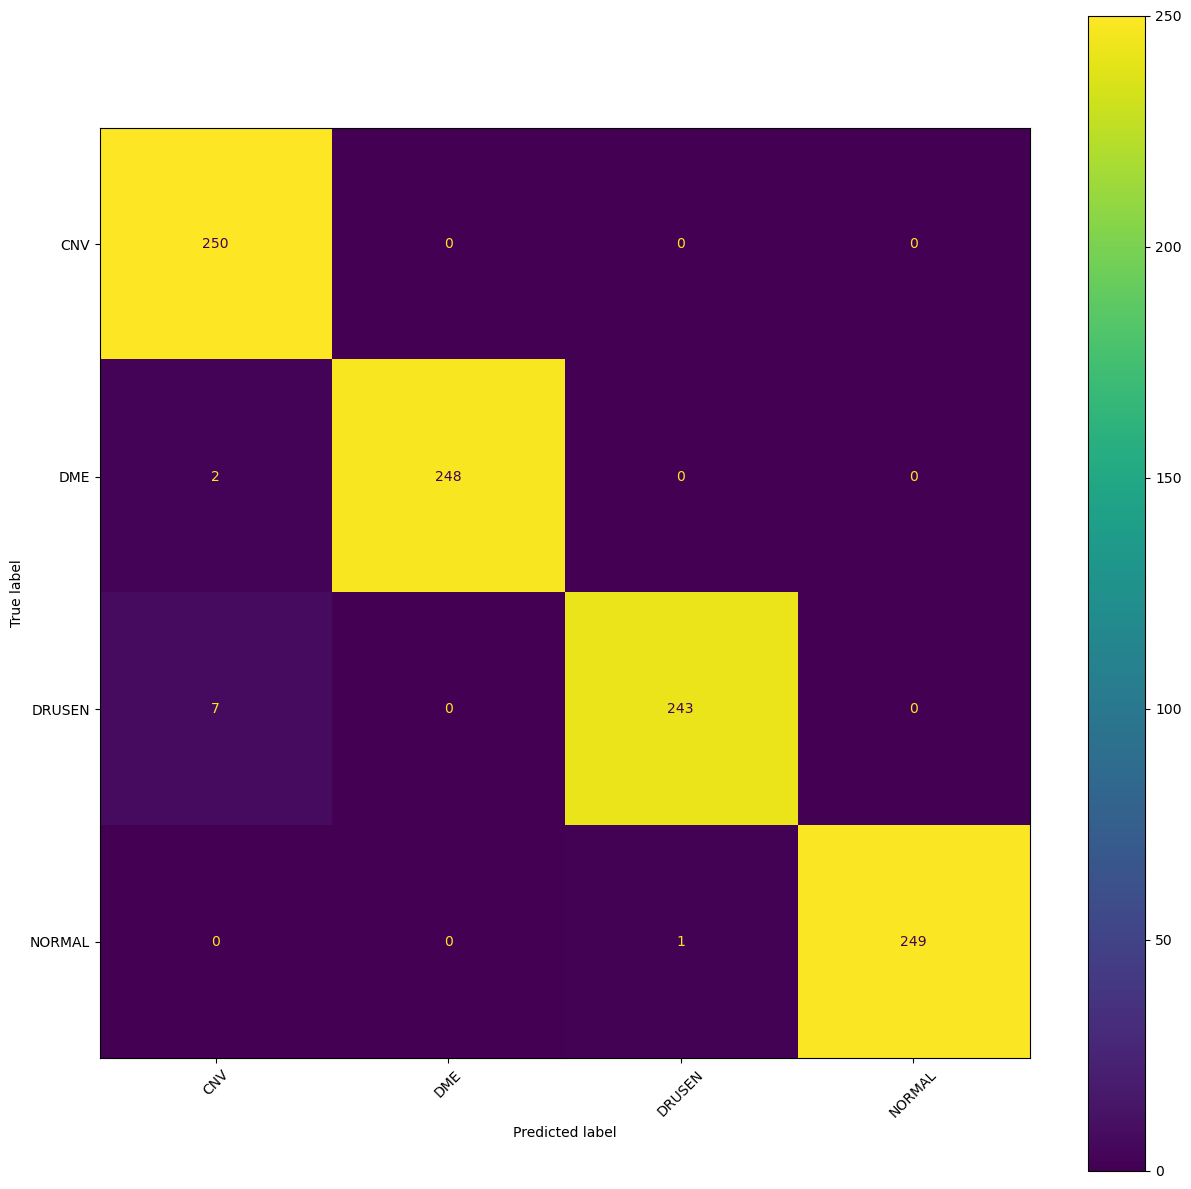

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
outputs = trainer.predict(test_ds)
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = test_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred, target_names=labels, digits=4)
print(report)

              precision    recall  f1-score   support

         CNV     0.9653    1.0000    0.9823       250
         DME     1.0000    0.9920    0.9960       250
      DRUSEN     0.9959    0.9720    0.9838       250
      NORMAL     1.0000    0.9960    0.9980       250

    accuracy                         0.9900      1000
   macro avg     0.9903    0.9900    0.9900      1000
weighted avg     0.9903    0.9900    0.9900      1000



# Inference

In [ ]:
from torchvision.datasets import ImageFolder

image_path = "oct/test/CNV/CNV-1016042-4.jpeg"

from PIL import Image
image = Image.open(image_path)
image.show()


In [ ]:
pipe(image)

NameError: name 'pipe' is not defined